# Reproduce  H. Huang , et. al , Faraday Discuss., 2018, 208, 555 – 573 

This notebook demonstrates reproducing the results of the paper with [Larch](https://xraypy.github.io/xraylarch/xafs/) using the corresponding published dataset (raw data). 


Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) **Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study.** Faraday Discussions. V. 208. pp. 555-573. DOI: [10.1039/c7fd00221a](https://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.


For more details about Larch, see [Larch Website](https://xraypy.github.io/xraylarch/xafs/)

## Reproduce Figure 4 - XANES Analysis
The first set of XAS results in the paper are in [Figure 4](https://pubs.rsc.org/image/article/2018/fd/c7fd00221a/c7fd00221a-f4_hi-res.gif)

To reproduce this image we need to:
- A: Identify the XANES data used (SnO2, Air, Ar, H2 and Sn foil)
  - Plot normalised flattened mE of the spectra on the range 29190 – 29450 
  - Plot first derivate of the spectra on the range 29190 – 29215
- B: Take Sn foil and SnO2 and do LCF of the peaks against H2, Ar, and Air
- C: Take Sn K-Edge of H2/H2 and SnO2 and do LCF of the peaks against H2, Ar, and Air

|Key|Content|
|:--|:--|
|OC|parent|
|OCA| Ar treated|
|OCH| H2 treated|
|OCO|air-treated|

In [1]:
# Library with the functions that rplicate those provided by athena
# normalisation, merging, re-binning, LCF
# and visualisation (plotting)
import lib.manage_athena as athenamgr  

# File handling
from pathlib import Path

#plotting library
import matplotlib.pyplot as plt
# inline: shows plot in notebook
# tk: shows plot in popup
%matplotlib inline 

### Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

### Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch provinding the custom column names. 

We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


In [2]:
# variables that can be changed to process different datasets
data_path = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii"

data_mappings={"PtSn":  "*_PtSn_OC_A*",
              "Air":  "*_PtSn_OCO_A*",
              "Ar":  "*_PtSn_OCA_A*",
              "H2":  "*_PtSn_OCH_A*",
              "PtSn H":  "*_PtSn_OC_H*", 
              "Air H":  "*_PtSn_OCO_H*",
              "Ar H":  "*_PtSn_OCA_H*",
              "H2 H":  "*_PtSn_OCH_H*",}

f_prefix = "PtSn_KEdge"
column_labels = "energy time I0 It Iref  mu lnItIref"

show_graph = True # False to prevent showing graphs

### Get fata and merge results for each sample in list
The below reads the raw readings for eache of the samples in data mappings and merges them to create the signals to be processed.



In [3]:
# start processing createa an output dir and sets the logger
source_path, out_path = athenamgr.files_setup(f_prefix, data_path)
print(source_path, out_path)


merged_results={}
# read all samples, merge and then normalise
for a_sample in data_mappings:
    files_list = athenamgr.get_files_list(source_path, data_mappings[a_sample])

    # read the files for each sample

    sample_list = []

    for i_count, a_file  in enumerate(files_list):
        file_name = a_file.name
        f_suffix = str(i_count).zfill(4) 
        p_name = f_prefix+f_suffix
        p_path = Path(out_path , p_name + ".prj")
        a_group = athenamgr.read_text(a_file, column_labels)
        sample_list.append(a_group)
        
    # merge readings for sample
    merged_xas = athenamgr.merge_readings(sample_list)

    # rename group (same as the file name)
    merged_xas.filename = a_sample
    merged_results[a_sample] = merged_xas
    # calculate pre-edge and post edge and add them to group
    # using defaults
    xas_data = athenamgr.fit_pre_post_edge(merged_xas)

# results in the paper are recalibrated to 29204
recalibrate_e0_to = 29204

for a_sample in merged_results:
    merged_results[a_sample] = athenamgr.recalibrate_energy(merged_results[a_sample], recalibrate_e0_to)


C:\harwell\PSDI_test\wf_data\pub_037\XAFS_prj\Sn K-edge\ascii PtSn_KEdge


### Get standards
The code below reads the Sn Foil and SnO2 project and retrieves the foil data used to copare to the readings


In [4]:
# get the Sn foil from project:
sn_foil = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn foil.prj"
# read the input file 
sn_foil_prj = athenamgr.read_project(sn_foil)

sn_foil_group = athenamgr.get_group(sn_foil_prj, 'merge')
sn_foil_group.filename = "Sn Foil"
sn_foil_group = athenamgr.recalibrate_energy(sn_foil_group, recalibrate_e0_to)
merged_results["Sn Foil"] = sn_foil_group

# get the Sn O2 standard from project:
sno2 = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/SnO2 0.9 2.6-13.5 gbkg.prj"
# read the input file 
sno2_prj = athenamgr.read_project(sno2)

sno2_group = athenamgr.get_group(sno2_prj, "SnO2_0_9_2_6_13_5_0_8_1_0_with_theory")#'SnO2_0_9')
sno2_group.filename = "SnO2"
sno2_group = athenamgr.recalibrate_energy(sno2_group, recalibrate_e0_to)
merged_results["SnO2"] = sno2_group

### Plot the mu signals for the reading and the Sn Foil

These are the plots shown on Fig. 4 A

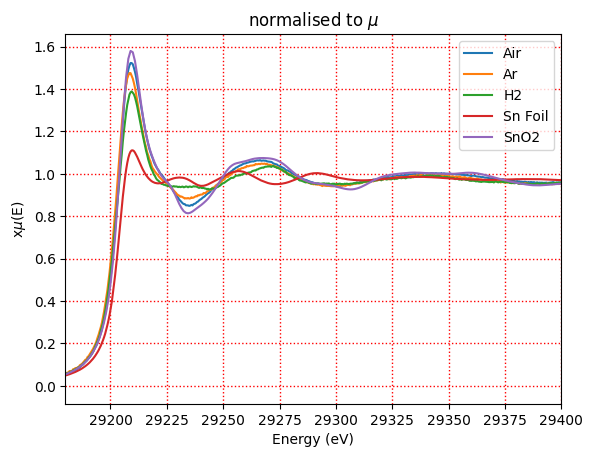

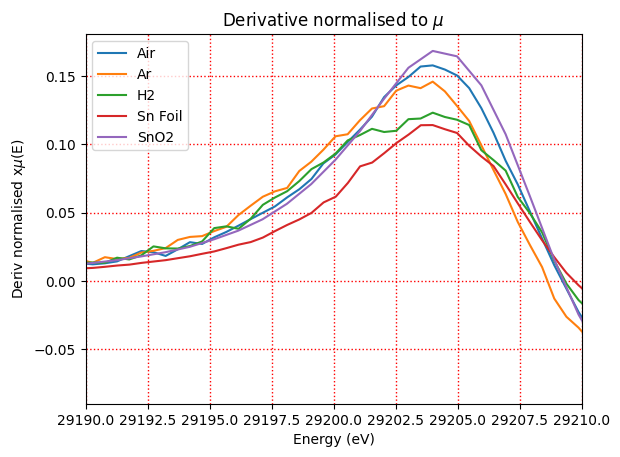

In [5]:
include_groups = ["Air", "Ar", "H2", "Sn Foil", "SnO2"]
for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_normalised(merged_results[a_sample])
    
plt.xlim([29180, 29400])
plt.show()

for a_sample in merged_results:
    if merged_results[a_sample].filename in include_groups:
        plt = athenamgr.plot_derivative(merged_results[a_sample])
    
plt.xlim([29190, 29210])
plt.show()

### Linear combination fitting (LCF)
Lineal combination fitting with defaults for the H2, Ar and Air readings (Shown on Fig. 4 B)

In [6]:
# import custom plot functions (replicate plots in paper)
import paper01_plots as c_plots

In [7]:
lcf_components = [merged_results["Sn Foil"],merged_results["SnO2"]] # List of groups to use as components 
r_H2 = athenamgr.lcf_group(merged_results["H2"], lcf_components)
r_Ar = athenamgr.lcf_group(merged_results["Ar"], lcf_components)
r_Air = athenamgr.lcf_group(merged_results["Air"], lcf_components)

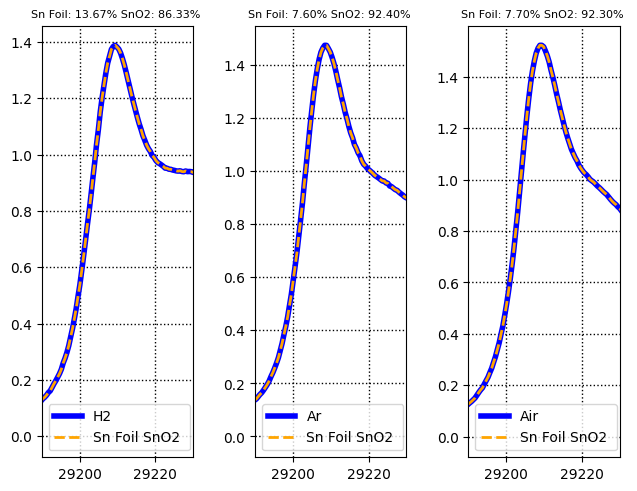

Sn Foil: 13.67% SnO2: 86.33% 


In [8]:
c_plots.compare_lcf_plot([merged_results["H2"],r_H2], [merged_results["Ar"],r_Ar], [merged_results["Air"],r_Air])
plt.show()

print(r_H2.arrayname)

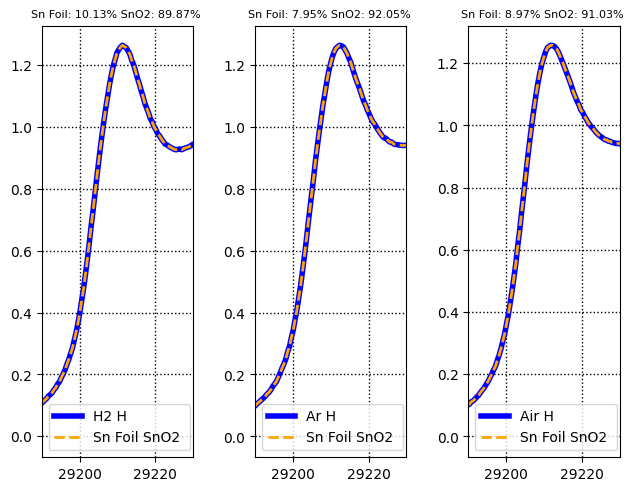

In [9]:
r_HH2 = athenamgr.lcf_group(merged_results["H2 H"], lcf_components)
r_HAr = athenamgr.lcf_group(merged_results["Ar H"], lcf_components)
r_HAir = athenamgr.lcf_group(merged_results["Air H"], lcf_components)

c_plots.compare_lcf_plot([merged_results["H2 H"],r_HH2], [merged_results["Ar H"],r_HAr], [merged_results["Air H"],r_HAir])
plt.show()

In [10]:
print("Goodness of LCF fits")
print ("LCF for H2:\t", "%.4f" % r_H2.rfactor)
print ("LCF for Ar:\t", "%.4f" % r_Ar.rfactor)
print ("LCF for Air:\t", "%.4f" % r_Air.rfactor)
print ("LCF for H\\H2:\t","%.4f" % r_HH2.rfactor)
print ("LCF for H\\Ar:\t","%.4f" % r_HAr.rfactor)
print ("LCF for H\\Air:\t","%.4f" % r_HAir.rfactor)


Goodness of LCF fits
LCF for H2:	 0.0007
LCF for Ar:	 0.0004
LCF for Air:	 0.0004
LCF for H\H2:	 0.0023
LCF for H\Ar:	 0.0028
LCF for H\Air:	 0.0026


## Reproduce Figure 5 XAS Processing
Rebin is required for XAS processing (see [Athena Manual](https://bruceravel.github.io/demeter/documents/Athena/process/rebin.html). So after the XANES analysis

In [49]:
# Rebin Ar, Air and H2 Samples 
rebin_labels = ["H2", "Ar", "Air"]
rebinned_groups = {}
rebinned_gr=None
for a_sample in merged_results:
    if a_sample in rebin_labels:
        rebinned_gr = athenamgr.rebin_group(merged_results[a_sample])
        rebinned_gr.arrayname = a_sample+" Rebbined"
        rebinned_groups[a_sample+" Rebbined"] = rebinned_gr
        print(len(rebinned_gr.energy),"to", len(merged_results["Ar"].energy))

athenamgr.save_groups([rebinned_groups["H2 Rebbined"],rebinned_groups["Ar Rebbined"],rebinned_groups["Air Rebbined"]], "rebinned.prj")

378 to 2093
378 to 2093
378 to 2093


['H2 Rebinned', 'Ar Rebinned', 'Air Rebinned']


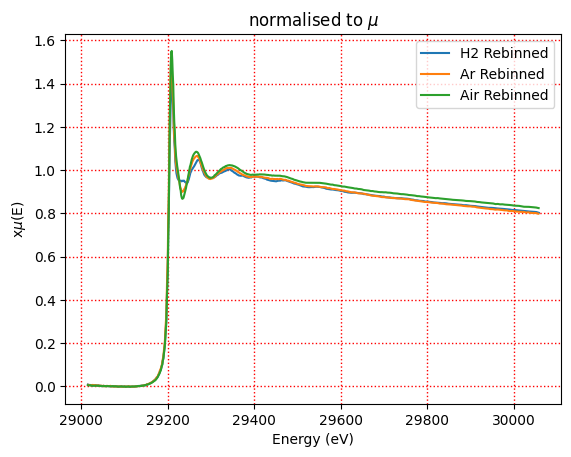

In [18]:
# read the input file 
athena_prj = athenamgr.read_project("rebinned.prj")

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
print(group_names)
for a_group in athena_groups:
    athenamgr.calc_with_defaults(a_group)
    plt = athenamgr.plot_normalised(a_group)
    plt.show

In [19]:
# Fitting input variables
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395a.cif"] #Pt3Sn for Sn
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1690711.cif"] #SnO2
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1680385.cif"] #PtO2
crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395b.cif"] #Pt3Sn for Pt

crystal_files = ["C:/harwell/PSDI_test/wf_data/pub_037/additional/1690711.cif",
                 "C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395a.cif",
                 "C:/harwell/PSDI_test/wf_data/pub_037/additional/1680385.cif",
                 "C:/harwell/PSDI_test/wf_data/pub_037/additional/1692395b.cif",] #

gds_parms_f = "SnK_edge_gds.csv"
sel_paths_f = "SnK_edge_sp.csv"

show_graph = False # False to prevent showing graphs

# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=0 
fit_vars['kmax']=10
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=0.0
fit_vars['rmax']=5.0

# Need to specify the absorbing atom and maximum radius
absorbing_atoms = ["Sn","Pt","O","Pt"]
max_radius = 8.0

### Atoms and FEFF

Larch does larch does not include a means for running atoms. Atoms is needed to get input for feff and calculate paths. Currently, the fastest option is to run Artemis to obtain the input (.inp) file for feff from a crystal file ('.cif' or '.inp')

The code below shows how subprocess can be used to call perl, execute a small perl script that runs Artemis Atoms, and saves the output file ('inp') in a new directory.

The file can then be used to run FEFF from Larch to calculate scattering paths.


In [20]:
# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files, absorbing_atoms, max_radius)

 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : comment: None given
 : Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1690711.cif
 : Structure Summary:  Sn2 O4
 : Reduced formula:  SnO2
 : space group: (P4_2/mnm), space number:  (136)
 : abc:  3.130000   4.609000   4.609000
 : angles: 90.000000  90.000000  90.000000
 : sites: 6
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique pot

 : 142     0.349    16.000     4   5.9694 neglected
 : 143     0.846    16.000     4   5.9694 neglected
 : 144     2.417    16.000     3   5.9784 neglected
 : 145     0.481     4.000     6   5.9836 neglected
 : 146     0.316     4.000     5   5.9836 neglected
 : 147     0.634     4.000     5   5.9836 neglected
 : 148     0.300     8.000     6   6.0011 neglected
 : 149     0.250     8.000     5   6.0011 neglected
 : 150     0.816     8.000     5   6.0011 neglected
 : 151     0.157     8.000     6   6.0011 neglected
 : 152     0.697     4.000     6   6.0011 neglected
 : 46 paths kept,  152 examined.
 : Feff done.  Have a nice day.
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : comment: None given
 : Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1692395a.cif
 : Structure Summary:  Sn1 Pt3
 : Reduced formula:  SnPt3
 : space group: (Pm-3m), space number:  (221)
 : abc: 

 : 95     0.008    32.000     4   7.2179 neglected
 : 96     0.014    32.000     4   7.2179 neglected
 : 97     0.146    32.000     3   7.2674 neglected
 : 98     0.236    32.000     3   7.2674 neglected
 : 99     0.215    32.000     3   7.2674 neglected
 : 100     0.048    32.000     3   7.2878 neglected
 : 101     0.133    32.000     3   7.3438 neglected
 : 102     0.294    32.000     4   7.3438 neglected
 : 103     0.109    16.000     4   7.3438 neglected
 : 104     0.108    32.000     4   7.3438 neglected
 : 105     0.084    16.000     4   7.3438 neglected
 : 106     5.933    32.000     2   7.4216
 : 107     2.106    16.000     2   7.4216 neglected
 : 108     0.756    32.000     3   7.5426 neglected
 : 109     0.635    32.000     3   7.5426 neglected
 : 110     0.522    32.000     3   7.5426 neglected
 : 111     1.605    32.000     3   7.5426 neglected
 : 112     1.234    32.000     3   7.5426 neglected
 : 113     1.871    32.000     3   7.5426 neglected
 : 114     1.460    32.000 

 : 76    22.534    12.000     3   5.5304
 : 77     5.671    12.000     3   5.5464
 : 78     5.617    12.000     3   5.5464
 : 79     7.705     8.000     4   5.5464
 : 80     7.721     8.000     4   5.5464
 : 81     3.671     8.000     4   5.5464
 : 82    21.530     6.000     2   5.5519
 : 83    31.466     6.000     2   5.5745
 : 84     4.029    12.000     3   5.5784
 : 85     3.194     8.000     4   5.5785
 : 86     2.673     4.000     4   5.6812
 : 87     2.418     4.000     4   5.6812 neglected
 : 88     4.837     8.000     4   5.6812
 : 89    11.169    12.000     4   5.7086
 : 90     8.157     6.000     4   5.7086
 : 91     8.308     6.000     4   5.7086
 : 92    11.281    12.000     4   5.7133
 : 93    10.931    12.000     4   5.7133
 : 94     9.408    12.000     4   5.7181
 : 95     5.207     6.000     4   5.7181
 : 96     5.270     6.000     4   5.7181
 : 97     4.548     6.000     4   5.7454
 : 98     8.682    12.000     4   5.7454
 : 99     4.894     6.000     3   5.7800
 : 100

 : 11     9.096     8.000     2   4.8586
 : 12     0.413    16.000     3   5.2344 neglected
 : 13     0.713    32.000     3   5.2344 neglected
 : 14     1.928    32.000     3   5.2344 neglected
 : 15     1.422    32.000     3   5.2344 neglected
 : 16     2.354    32.000     3   5.2344 neglected
 : 17     8.749    12.000     2   5.6102
 : 18     2.047     8.000     3   5.6102 neglected
 : 19     0.649     4.000     3   5.6102 neglected
 : 20    26.845    16.000     3   5.6102
 : 21    11.163     8.000     3   5.6102
 : 22     4.659     8.000     4   5.6102
 : 23     1.520     4.000     4   5.6102 neglected
 : 24     0.714     8.000     4   5.6102 neglected
 : 25     0.234     4.000     4   5.6102 neglected
 : 26     0.205    16.000     4   5.6102 neglected
 : 27     0.314    32.000     4   5.6102 neglected
 : 28    30.222     8.000     4   5.6102
 : 29    10.988     4.000     4   5.6102
 : 30     0.098    16.000     4   5.6102 neglected
 : 31     0.093    32.000     4   5.6102 neglected

In [54]:
from larch import Interpreter
session = Interpreter()
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_parms_f, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

Sheet(cells=(Cell(column_start=0, row_end=28, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [55]:
#read the gds data and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_parms_f)

#### Show all FEFF paths

To select a path change the value of the select column to 1 in the table displayed after running the cell below.

In [23]:
path_sheet = fit_manager.show_feff_paths(crystal_files)#('FeS2.inp')
display(path_sheet)

Reading from 1690711_feff
1690711_feff path and 1690711_feff\files.dat found
Reading from: 1690711_feff\files.dat
1: comment: None given                                    Feff 6L.02  potph 4.12
2: Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1690711.cif
3: Structure Summary:  Sn2 O4
4: Reduced formula:  SnO2
5: space group: (P4_2/mnm), space number:  (136)
6: abc:  3.130000   4.609000   4.609000
7: angles: 90.000000  90.000000  90.000000
8: sites: 6
9: Abs   Z=50 Rmt= 1.146 Rnm= 1.443 K shell
10: Pot 1 Z= 8 Rmt= 0.863 Rnm= 1.083
11: Pot 2 Z=50 Rmt= 1.141 Rnm= 1.429
12: Gam_ch=1.000E+01 H-L exch
13: Mu=-3.184E+00 kf=2.310E+00 Vint=-2.352E+01 Rs_int= 1.570
Reading from 1692395a_feff
1692395a_feff path and 1692395a_feff\files.dat found
Reading from: 1692395a_feff\files.dat
1: comment: None given                                    Feff 6L.02  potph 4.12
2: Source:  C:\harwell\PSDI_test\wf_data\pub_037\additional\1692395a.cif
3: Structure Summary:  Sn1 Pt3
4: Reduced formula:  

Sheet(cells=(Cell(column_end=7, column_start=0, row_end=267, row_start=0, squeeze_column=False, squeeze_row=Fa…

#### 2.5.2 Assing parameters to paths

To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                      |label    | s02 |e0   |sigma2   |deltar      |
|:----------------------    |------   |-----|-----|-------  |------------|
|1690711_feff/feff0001.dat | O.Sn.1	 |amp  | enot|ss_sno2_1|alpha\*reff
|1690711_feff/feff0002.dat | O.Sn.2	 |amp  | enot|ss_sno2_2|alpha\*reff
|1690711_feff/feff0003.dat | Sn.Sn.3 |amp  | enot|ss_sno2_3|alpha\*reff
|1692395a_feff/feff0001.dat| Pt.Pt.1 |amp  | enot|ss_ptsn_1|alpha\*reff
|1692395a_feff/feff0002.dat| Sn.Pt.2 |amp  | enot|ss_ptsn_2|alpha\*reff
|1692395a_feff/feff0003.dat| Pt.Pt.3 |amp  | enot|ss_ptsn_3|alpha\*reff
|1692395a_feff/feff0010.dat| Pt.Pt.10|amp  | enot|ss_ptsn_4|alpha\*reff
|1680385_feff/feff0001.dat | Pt.O.1  |amp  | enot|ss_o2pt_1|alpha\*reff
|1680385_feff/feff0002.dat | O.O.2A  |amp  | enot|ss_o2pt_2|alpha\*reff
|1680385_feff/feff0003.dat | O.O.3   |amp  | enot|ss_o2pt_3|alpha\*reff


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.


In [56]:
sp_sheet = fit_manager.show_selected_paths(path_sheet)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=11, row_start=0, squeeze_column=False, squeeze_row=Fal…

In [57]:
fit_manager.save_selected_paths_list(sp_sheet, sel_paths_f)
selected_paths = fit_manager.read_selected_paths_list(sel_paths_f, session)

### 2.6 Run Fit

XAS fitting is performed in three steps:

1. Create a Transform group to hold the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.

In [58]:
# run fit
fit_list = {}
for a_group in athena_groups:
    trans, dset, out = fit_manager.run_fit(a_group, gds, selected_paths, fit_vars, session)
    fit_list[a_group.filename]=[trans, dset, out]

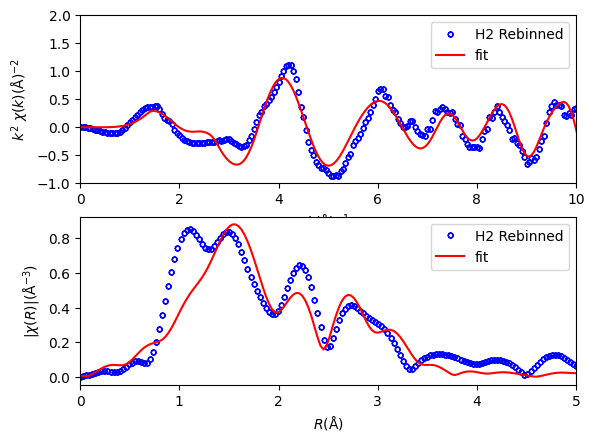

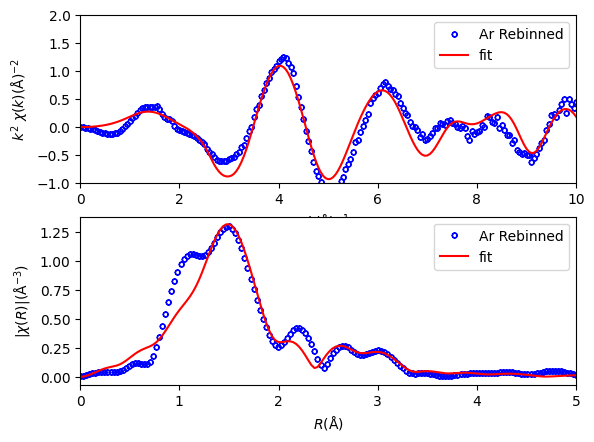

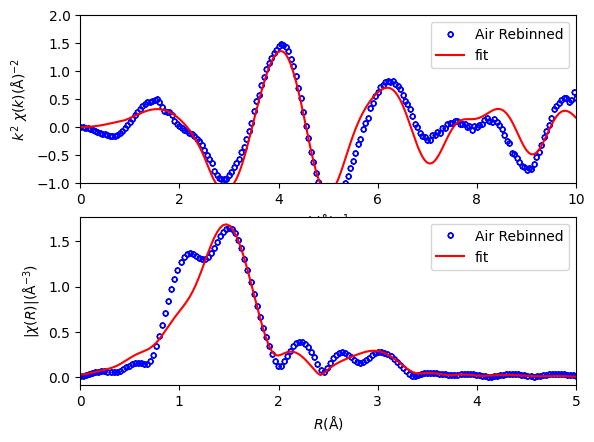

In [59]:
for a_fit in fit_list:
    chikr_p = c_plots.plot_markers(fit_list[a_fit][1],fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'], a_fit)
    chikr_p.show()

In [60]:
for a_fit in fit_list:
    fit_report = fit_manager.get_fit_report(fit_list[a_fit][2], session)
    print(fit_report)


=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  15, 324
   n_independent      =  32.831
   chi_square         =  14889.2855
   reduced chi_square =  835.022995
   r-factor           =  0.19882612
   Akaike info crit   =  230.827955
   Bayesian info crit =  253.198548
 
[[Data]]
   fit space          = 'r'
   r-range            = 0.000, 5.000
   k-range            = 0.000, 10.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['1690711_feff/feff0001.dat', '1690711_feff/feff0002.dat', '1690711_feff/feff0003.dat', '1692395a_feff/feff0001.dat', '1692395b_feff/feff0002.dat', '1692395a_feff/feff0003.dat', '1692395a_feff/feff0010.dat', '1680385_feff/feff0001.dat', '1680385_feff/feff0002.dat', '1680385_feff/feff0003.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=6.5492e-04, std=1.5375e-04)
   epsilon_r          = 0.00584232
   n_independent      = 32.831
 
[[Variables]]
   alpha          =  0.04038216 +/-unkn

In [ ]:
fit_manager.save_selected_paths_list(sp_sheet, sel_paths_f)